# Analysis of dynamic network ABM
Standard networks, no SDA yet

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
# from mesa.batchrunner import BatchRunner
import itertools

In [2]:
#from model import ConsumatModel
from model_dynamicnetwork_newdata import ConsumatModel

In [3]:
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42  # Seed for reproducibility
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


## Network topology

### Watts-Strogatz Network
- **Type:** Small-world network
- **Known For:** High clustering coefficient and short average path lengths, which mimic many real-world social networks.
- **Formation:** Starts with a ring of `n` nodes each connected to `k` nearest neighbors. Rewires each edge with probability `p` to a randomly chosen node.
- **Key Parameters:**
  - `n`: Number of nodes
  - `k`: Number of nearest neighbors in the initial ring topology
  - `p`: Probability of rewiring each edge

### Barabasi-Albert Network
- **Type:** Scale-free network
- **Known For:** Its degree distribution follows a power law, which is typical for many large networks such as the internet, citation networks, and some social networks.
- **Formation:** Begins with a small number of nodes and adds new nodes one at a time. Each new node is connected to `k` existing nodes with a probability that depends on the number of links that the existing nodes already have.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges to attach from a new node to existing nodes

### Random Regular Network
- **Type:** Regular graph
- **Known For:** Every node has the same number of connections. This uniformity can represent idealized conditions in network modeling.
- **Formation:** Constructed by connecting each node with `d` neighbors chosen at random, ensuring each has the same degree, while avoiding self-loops and duplicate edges.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `d`: Degree of each node

### Holme-Kim Network
- **Type:** Small-world network with scale-free properties
- **Known For:** Combines high clustering and short path lengths (like Watts-Strogatz) with a degree distribution that follows a power law (like Barabasi-Albert).
- **Formation:** Starts like the Barabasi-Albert model by adding one node at a time, connecting to `m` existing nodes based on their degree. After each edge creation, with probability `p` adds an additional edge forming a triangle.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges each new node will attempt to make
  - `p`: Triad formation probability



In [4]:

def run_simulation(model, num_steps):
    adoption_rates = []

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    all_simulation_data = {}
    
    for config_name, config in configurations.items():
        print(f"Running simulations for {config_name} with parameters: {config}")
        
        all_simulation_data[config_name] = []
        
        for simulation in range(num_simulations):
            model = ConsumatModel(config)
            model_data, agent_data = run_simulation(model, num_steps)
            all_simulation_data[config_name].append(model_data)

        aggregated_data = pd.concat(all_simulation_data[config_name]).groupby(level=0).mean()
        results[config_name] = aggregated_data

    return results, all_simulation_data


def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count





In [5]:
def plot_adoption_rates(all_simulation_data, varying_params):
    param_name = list(varying_params.keys())[0]
    
    # Group configurations by network
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    # Plot each network's configurations
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 6))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            tp_value = config_name.split('_TP_')[1]
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], marker='o', label=f'{param_name} {tp_value}')
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.grid(True)
        plt.legend()
        plt.show()



def plot_network_metrics(results, varying_params):
    param_name = list(varying_params.keys())[0]
    
    network_groups = {}
    for config_name in results.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 5))
        
        metrics_plotted = False
        for config_name in config_names:
            aggregated_data = results[config_name]
            tp_value = config_name.split('_TP_')[1]
            if 'Average Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Degree'], marker='o', label=f'Average Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Variance of Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Variance of Degree'], marker='o', label=f'Variance of Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Clustering' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Clustering'], marker='o', label=f'Average Clustering {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Path Length' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Path Length'], marker='o', label=f'Average Path Length {param_name} {tp_value}', linestyle='--')
                metrics_plotted = True
        
        if metrics_plotted:
            plt.xlabel('Step')
            plt.ylabel('Metric Value')
            plt.title(f'Network Metrics Over Time for {network_name}')
            plt.legend()
            plt.show()


def plot_decision_modes(network_configurations, num_steps):
    for network_name, config in network_configurations.items():
        model = ConsumatModel(config)
        _, agent_data = run_simulation(model, num_steps)
        
        decision_modes_count = generate_decision_modes_count(agent_data)
        print(f"Decision Mode Counts for {network_name} network:")
        print(decision_modes_count)

        plt.figure(figsize=(12, 8))
        plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label='Repeat', linestyle='-', marker='o')
        plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label='Imitate', linestyle='--', marker='x')
        plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label='Deliberate', linestyle='-.', marker='s')
        plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label='Social Compare', linestyle=':', marker='d')
        plt.title(f'Decision Modes over Time for {network_name} network')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

### Vary network parameters

In [12]:

def generate_configurations(base_config, varying_params):
    keys, values = zip(*varying_params.items())
    configurations = []
    
    for combination in itertools.product(*values):
        config = base_config.copy()
        config.update(dict(zip(keys, combination)))
        configurations.append(config)
    
    return configurations


Running simulations for Watts-Strogatz_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_pro

Running simulations for Watts-Strogatz_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.62s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Barabasi-Albert_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.34s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Barabasi-Albert_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.11s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Barabasi-Albert_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.90s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Barabasi-Albert_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.84s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Random Regular_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.66s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Random Regular_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Random Regular_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.56s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Running simulations for Random Regular_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.98s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.06s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.59s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


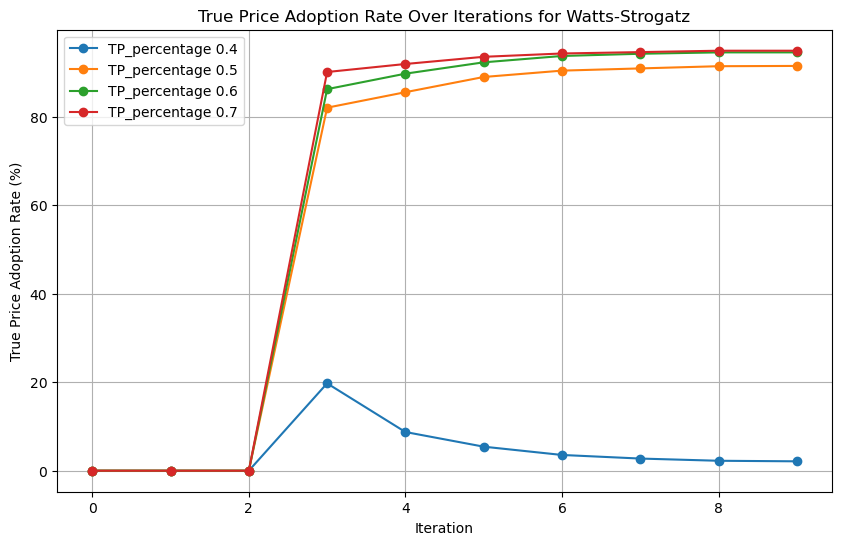

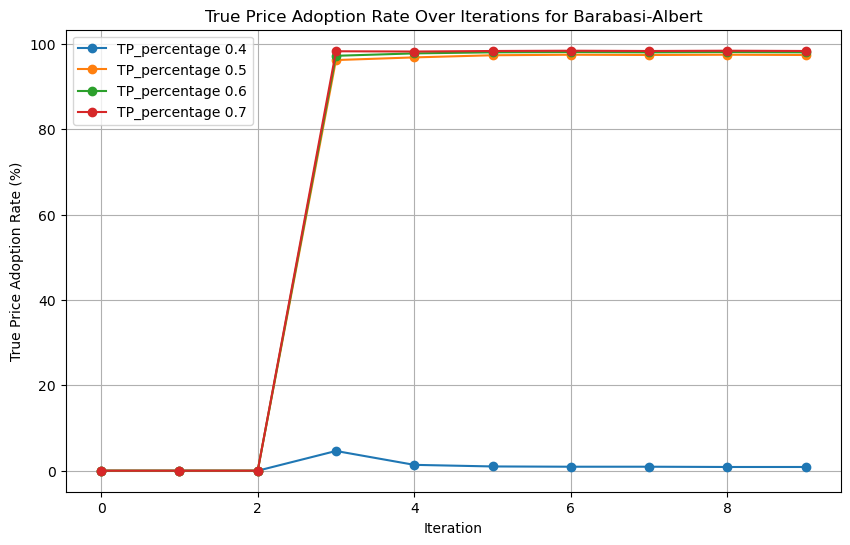

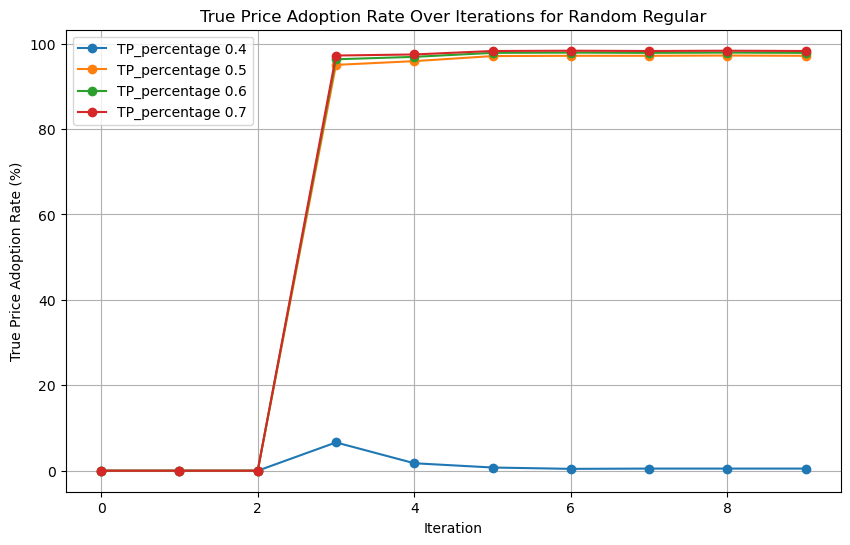

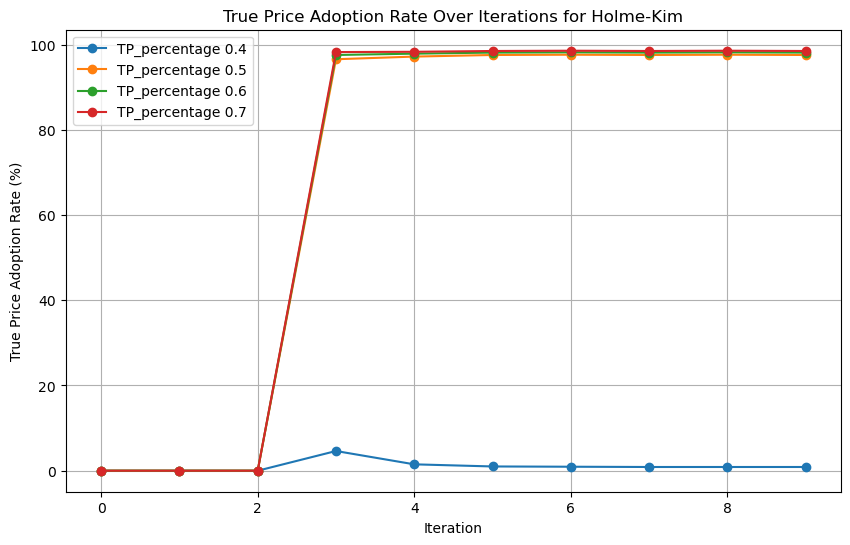

In [13]:
# Example network configurations (replace with actual configurations)
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Varying parameters
varying_params = {
    'TP_percentage': [0.4, 0.5, 0.6, 0.7],
}

num_simulations = 1
num_steps = 10

# Generate configurations
all_configurations = {}
for network_name, net_config in network_configurations.items():
    net_configs = generate_configurations({**base_config, **net_config}, varying_params)
    for idx, config in enumerate(net_configs):
        config_name = f"{network_name}_Config_{idx+1}_TP_{config['TP_percentage']}"
        all_configurations[config_name] = config

# Run all simulations
results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

# Plotting results
plot_adoption_rates(all_simulation_data, varying_params)



Running simulations for Watts-Strogatz_p_0.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_pro

Running simulations for Watts-Strogatz_p_0.10 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.69s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.20 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.13s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.30 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.26s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.40 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:13<00:00, 13.37s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.50 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.22s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.60 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.90s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.70 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:00<00:00, 12.03s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.80 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:05<00:00, 12.52s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_0.90 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:00<00:00, 12.01s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Watts-Strogatz_p_1.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.67s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:35<00:00, 27.52s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.10 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:24<00:00, 26.48s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.20 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:29<00:00, 26.91s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.30 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:23<00:00, 26.33s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.40 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:22<00:00, 26.26s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.50 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:25<00:00, 26.56s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Running simulations for Holme-Kim_p_0.60 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:28<00:00, 26.82s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.70 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:27<00:00, 26.78s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.80 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:23<00:00, 26.30s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_0.90 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:23<00:00, 26.32s/it]
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:21: FutureWarning: The Mesa Model class was not initialized. In the future, yo

Running simulations for Holme-Kim_p_1.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:592: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  
C:\Users\elpha\Downloads\ThesisNew\Networks\No homophily\New data\model_dynamicnetwork_newdata.py:412: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.products = self.create_products()
Simulation Progress: 100%|█████████████████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.17s/it]


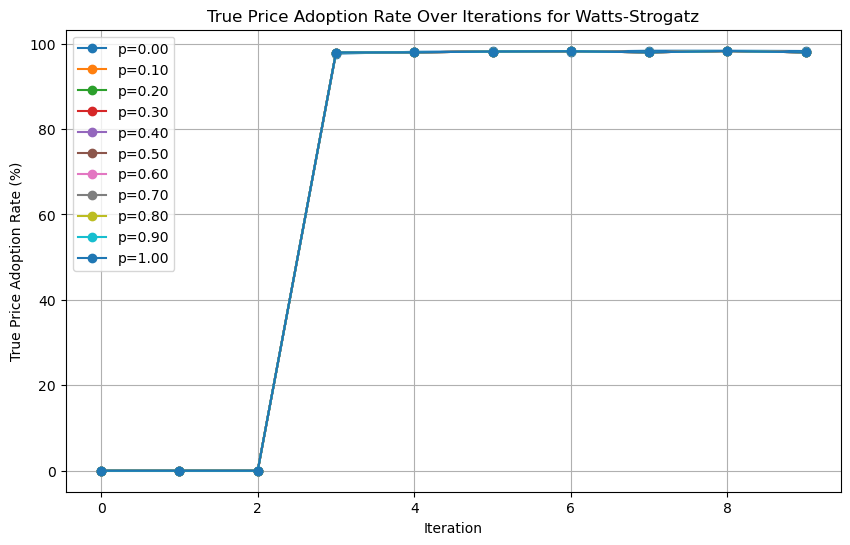

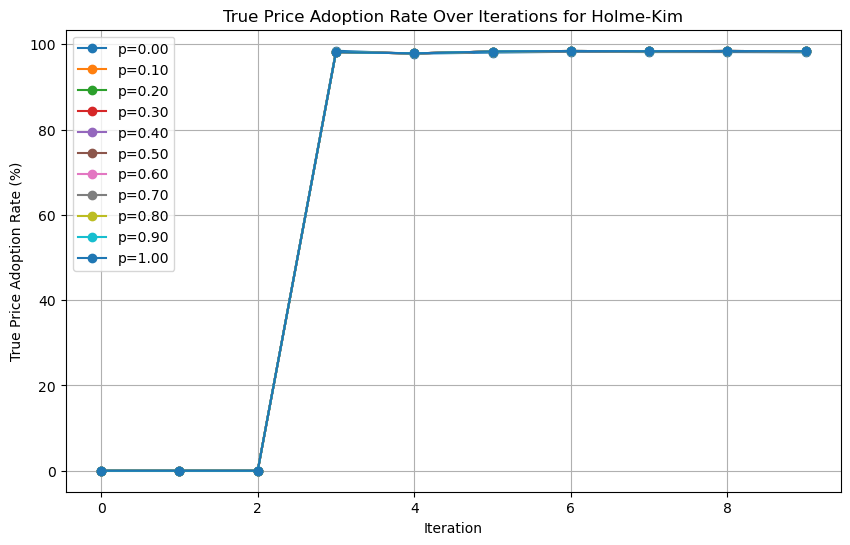

In [14]:
# Parameters to vary
parameter_name = 'p'
parameter_values = np.linspace(0, 1, 10)
num_steps = 10
num_simulations = 1

# Base configuration
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42  # Seed for reproducibility
}

# Network configurations
network_configurations = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 8,
            'p': 0.3
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 8,
            'p': 0.3
        }
    }
}

# Parameters to vary
parameter_name = 'p'
parameter_values = np.arange(0, 1.1, 0.10)
num_steps = 10
num_simulations = 1

# Generate configurations
def generate_varying_param_configurations(base_config, network_configurations, parameter_name, parameter_values):
    all_configurations = {}
    for network_name, net_config in network_configurations.items():
        for value in parameter_values:
            config = base_config.copy()
            config.update(net_config)
            config['network_params'][parameter_name] = value
            config_name = f"{network_name}_p_{value:.2f}"
            all_configurations[config_name] = config
    return all_configurations

all_configurations = generate_varying_param_configurations(base_config, network_configurations, parameter_name, parameter_values)

# Run all simulations
results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

# Plotting results
def plot_varying_parameter_results(all_simulation_data, parameter_name):
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_p_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 6))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            p_value = config_name.split('_p_')[1]
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], marker='o', label=f'p={p_value}')
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

# Plot results for adoption rates
plot_varying_parameter_results(all_simulation_data, parameter_name)


def run_simulation_for_tp_percentage(config, tp_percentages, num_steps):
    results_by_tp_percentage = []

    for tp_percentage in tqdm(tp_percentages, desc='TP Percentage Progress'):
        # Update the config with the current TP_percentage
        config['TP_percentage'] = tp_percentage
        
        # Run the simulation
        model = ConsumatModel(config)
        model_data, agent_data = run_simulation(model, num_steps)
        
        # Extract the adoption rates and decision modes from the DataFrame
        adoption_rates = model_data['Adoption Rates'].values
        decision_modes_count = generate_decision_modes_count(agent_data)
        
        # Store the adoption rates and decision modes for this TP_percentage
        results_by_tp_percentage.append((adoption_rates, decision_modes_count))
    
    return results_by_tp_percentage
# Base configuration
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

# Network configurations
network_configs = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 4,
            'p': 0.2
        }
    },
    'Barabasi-Albert': {
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 4
        }
    },
    'Random Regular': {
        'network_type': 'random_regular',
        'network_params': {
            'n': 1600,
            'd': 4
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 4,
            'p': 0.1
        }
    }
}

# Define a range of values for TP_percentage
tp_percentages = np.linspace(0.4, 0.9, 19)  # From 40% to 90%

# Hold the number of steps constant for each simulation
num_steps = 10

# Function to generate decision modes count DataFrame
def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count

# Run simulations and collect results for all networks
all_network_results = {}
for network_name, network_config in network_configs.items():
    print(f"Running simulations for {network_name} network...")
    config = base_config.copy()
    config.update(network_config)
    results_by_tp_percentage = run_simulation_for_tp_percentage(config, tp_percentages, num_steps)
    all_network_results[network_name] = results_by_tp_percentage

# Plot the results for each network
for network_name, results_by_tp_percentage in all_network_results.items():
    # Plot True Price Adoption Rates
    plt.figure(figsize=(10, 6))
    for i, (adoption_rates, _) in enumerate(results_by_tp_percentage):
        plt.plot(range(1, num_steps + 1), adoption_rates, label=f'TP_percentage = {tp_percentages[i]:.1f}', marker='o')
    plt.title(f'True Price Percentage Impact on Adoption Rate - {network_name}')
    plt.xlabel('Time Step')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Decision Modes
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Decision Modes for Different TP Percentages - {network_name}')

    mode_labels = ['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']
    for idx, mode in enumerate(mode_labels):
        ax = axs[idx // 2, idx % 2]
        for i, (_, decision_modes_count) in enumerate(results_by_tp_percentage):
            ax.plot(decision_modes_count.index, decision_modes_count[mode], label=f'TP_percentage = {tp_percentages[i]:.1f}', marker='o')
        ax.set_title(f'{mode} Mode')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Number of Agents')
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

### Sensitivity Analysis

### GSA

In [18]:
# Install specific versions of the libraries
!pip install SALib==1.4.8
!pip install numpy==1.26.4
!pip install pandas==2.2.0


     -------------------------------------- 778.7/778.7 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: SALib
    Found existing installation: SALib 1.5.0
    Uninstalling SALib-1.5.0:
      Successfully uninstalled SALib-1.5.0
     --------------------------------------- 15.8/15.8 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.0
    Uninstalling numpy-2.0.0:
      Successfully uninstalled numpy-2.0.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\elpha\\anaconda3\\Lib\\site-packages\\~umpy.libs\\libscipy_openblas64_-fb1711452d4d8cee9f276fd1449ee5c7.dll'
Consider using the `--user` option or check the permissions.



     --------------------------------------- 11.6/11.6 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2


In [19]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['preference_sustainability'],
    'seed': 42  # Seed for reproducibility
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage','max_increase_percentage', 'k', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1]] 
    },
    'Barabasi-Albert': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon','min_increase_percentage', 'max_increase_percentage', 'm'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Random Regular': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','d'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Holme-Kim': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','m', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20],[2, 10], [0, 1]] 
    }
}

In [20]:
# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)


C:\Users\elpha\AppData\Local\Temp\ipykernel_21120\3049819496.py:7: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


In [ ]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import json

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['epsilon'] = params[3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

# Run GSA for each network
for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    # Perform Sobol sensitivity analysis
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S2': Si['S2'].tolist(),
            'S1_conf': Si['S1_conf'].tolist(),
            'ST_conf': Si['ST_conf'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    # Save results to a JSON file
    with open(f'dynamic_sensitivity_results_preferencesustainability_{network_name}.json', 'w') as f:
        json.dump(results, f)


Running GSA for Watts-Strogatz network...



Running simulations for Watts-Strogatz:   4%|█▍                                  | 176/4608 [24:30<13:22:05, 10.86s/it]

In [9]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget'],
    'seed': 42  # Seed for reproducibility
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage','max_increase_percentage', 'k', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1]] 
    },
    'Barabasi-Albert': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon','min_increase_percentage', 'max_increase_percentage', 'm'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Random Regular': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','d'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Holme-Kim': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','m', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20],[2, 10], [0, 1]] 
    }
}
# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import json

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['epsilon'] = params[3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

# Run GSA for each network
for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    # Perform Sobol sensitivity analysis
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S2': Si['S2'].tolist(),
            'S1_conf': Si['S1_conf'].tolist(),
            'ST_conf': Si['ST_conf'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    # Save results to a JSON file
    with open(f'dynamic_sensitivity_results_budget_{network_name}.json', 'w') as f:
        json.dump(results, f)



C:\Users\elpha\AppData\Local\Temp\ipykernel_9568\4110209560.py:102: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Watts-Strogatz network...



Running simulations for Watts-Strogatz: 100%|████████████████████████████████████| 4608/4608 [1:38:09<00:00,  1.28s/it]


                               ST   ST_conf
TP_percentage            1.051326  0.145675
satisfaction_threshold   0.103215  0.055502
uncertainty_threshold    0.107389  0.062135
epsilon                  0.033588  0.034528
min_increase_percentage  0.012149  0.017571
max_increase_percentage  0.064985  0.052430
k                        0.044409  0.039775
p                        0.082962  0.046632
                               S1   S1_conf
TP_percentage            0.888239  0.135275
satisfaction_threshold   0.009545  0.061967
uncertainty_threshold    0.038419  0.058833
epsilon                  0.000577  0.030439
min_increase_percentage -0.009136  0.016668
max_increase_percentage -0.001755  0.046073
k                       -0.018781  0.038223
p                        0.015488  0.045928
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.029595  0.106770
(TP_percentage, uncertainty_threshold)             -0.013092  0.10


Running simulations for Barabasi-Albert: 100%|███████████████████████████████████| 4096/4096 [2:35:28<00:00,  2.28s/it]


                               ST   ST_conf
TP_percentage            0.670195  0.128030
satisfaction_threshold   0.158347  0.065820
uncertainty_threshold    0.330092  0.103071
epsilon                  0.056167  0.047936
min_increase_percentage  0.000095  0.000080
max_increase_percentage  0.001288  0.002181
m                        0.186440  0.069825
                               S1   S1_conf
TP_percentage            0.464923  0.136268
satisfaction_threshold   0.006010  0.071052
uncertainty_threshold    0.065387  0.110390
epsilon                 -0.008193  0.042174
min_increase_percentage -0.000287  0.001648
max_increase_percentage -0.000241  0.006218
m                       -0.023210  0.080196
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.024728  0.138899
(TP_percentage, uncertainty_threshold)              0.098666  0.169729
(TP_percentage, epsilon)                            0.039606  0.141681
(TP_percenta


Running simulations for Random Regular: 100%|████████████████████████████████████| 4096/4096 [2:02:38<00:00,  1.80s/it]


                               ST   ST_conf
TP_percentage            0.937458  0.129801
satisfaction_threshold   0.081540  0.021681
uncertainty_threshold    0.106894  0.039019
epsilon                  0.026528  0.028585
min_increase_percentage  0.000430  0.000494
max_increase_percentage  0.020476  0.025549
d                        0.041705  0.019343
                               S1   S1_conf
TP_percentage            0.843373  0.127438
satisfaction_threshold   0.030031  0.045311
uncertainty_threshold   -0.016403  0.058187
epsilon                  0.011915  0.038530
min_increase_percentage  0.000538  0.002255
max_increase_percentage -0.014066  0.023246
d                       -0.022655  0.035967
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)            -0.045741  0.104555
(TP_percentage, uncertainty_threshold)             -0.005925  0.109325
(TP_percentage, epsilon)                           -0.064618  0.113233
(TP_percenta


Running simulations for Holme-Kim: 100%|█████████████████████████████████████████| 4608/4608 [2:40:50<00:00,  2.09s/it]


                               ST   ST_conf
TP_percentage            0.837956  0.132739
satisfaction_threshold   0.204639  0.074833
uncertainty_threshold    0.322125  0.087593
epsilon                  0.072040  0.050383
min_increase_percentage  0.043725  0.039575
max_increase_percentage  0.058288  0.049737
m                        0.120765  0.059296
p                        0.107715  0.059968
                               S1   S1_conf
TP_percentage            0.555034  0.150930
satisfaction_threshold   0.026648  0.079318
uncertainty_threshold    0.104182  0.097597
epsilon                  0.003711  0.051489
min_increase_percentage  0.002981  0.034421
max_increase_percentage  0.015873  0.040807
m                        0.011325  0.063521
p                       -0.031391  0.050504
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.080936  0.146747
(TP_percentage, uncertainty_threshold)              0.121082  0.14

In [7]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['preference_conformity'],
    'seed': 42  # Seed for reproducibility
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}


# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage','max_increase_percentage', 'k', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1]] 
    },
    'Barabasi-Albert': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon','min_increase_percentage', 'max_increase_percentage', 'm'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Random Regular': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','d'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Holme-Kim': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','m', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20],[2, 10], [0, 1]] 
    }
}
# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import json

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['epsilon'] = params[3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

# Run GSA for each network
for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    # Perform Sobol sensitivity analysis
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S2': Si['S2'].tolist(),
            'S1_conf': Si['S1_conf'].tolist(),
            'ST_conf': Si['ST_conf'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    # Save results to a JSON file
    with open(f'dynamic_sensitivity_results_preferenceconformity_{network_name}.json', 'w') as f:
        json.dump(results, f)



C:\Users\elpha\AppData\Local\Temp\ipykernel_9568\595342797.py:109: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Watts-Strogatz network...


Running simulations for Watts-Strogatz: 100%|████████████████████████████████████| 4608/4608 [1:40:40<00:00,  1.31s/it]


                               ST   ST_conf
TP_percentage            1.053004  0.152218
satisfaction_threshold   0.080439  0.040887
uncertainty_threshold    0.068657  0.036735
epsilon                  0.004393  0.003313
min_increase_percentage  0.031835  0.037776
max_increase_percentage  0.015479  0.024699
k                        0.048789  0.033864
p                        0.050339  0.034070
                               S1   S1_conf
TP_percentage            0.917953  0.133047
satisfaction_threshold   0.003046  0.047656
uncertainty_threshold    0.014848  0.049038
epsilon                  0.005780  0.011388
min_increase_percentage  0.016195  0.028807
max_increase_percentage -0.000753  0.023285
k                        0.000665  0.037091
p                       -0.015750  0.040662
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.068249  0.089942
(TP_percentage, uncertainty_threshold)             -0.005507  0.07

Running simulations for Barabasi-Albert: 100%|███████████████████████████████████| 4096/4096 [2:42:10<00:00,  2.38s/it]


                               ST   ST_conf
TP_percentage            0.795915  0.133089
satisfaction_threshold   0.157993  0.056581
uncertainty_threshold    0.215174  0.065591
epsilon                  0.046046  0.032731
min_increase_percentage  0.000049  0.000026
max_increase_percentage  0.017281  0.024918
m                        0.153768  0.070502
                               S1   S1_conf
TP_percentage            0.538057  0.129084
satisfaction_threshold   0.027533  0.062103
uncertainty_threshold    0.015842  0.083729
epsilon                 -0.004691  0.040129
min_increase_percentage -0.000785  0.001353
max_increase_percentage -0.002338  0.019914
m                       -0.006801  0.067306
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.046700  0.146040
(TP_percentage, uncertainty_threshold)              0.060964  0.144463
(TP_percentage, epsilon)                            0.019262  0.135684
(TP_percenta

Running simulations for Random Regular: 100%|████████████████████████████████████| 4096/4096 [2:06:02<00:00,  1.85s/it]


                               ST   ST_conf
TP_percentage            0.928207  0.125109
satisfaction_threshold   0.119097  0.053042
uncertainty_threshold    0.054705  0.018260
epsilon                  0.009937  0.013904
min_increase_percentage  0.000295  0.000278
max_increase_percentage  0.001554  0.001943
d                        0.050607  0.036821
                               S1   S1_conf
TP_percentage            0.845294  0.129013
satisfaction_threshold   0.009779  0.062110
uncertainty_threshold   -0.014489  0.039276
epsilon                 -0.008619  0.013734
min_increase_percentage -0.002206  0.002229
max_increase_percentage  0.002465  0.007603
d                       -0.010733  0.044543
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.004918  0.102791
(TP_percentage, uncertainty_threshold)             -0.002774  0.089895
(TP_percentage, epsilon)                           -0.016352  0.091541
(TP_percenta

Running simulations for Holme-Kim: 100%|█████████████████████████████████████████| 4608/4608 [2:44:26<00:00,  2.14s/it]


                               ST   ST_conf
TP_percentage            0.824911  0.138813
satisfaction_threshold   0.253090  0.079441
uncertainty_threshold    0.216172  0.071103
epsilon                  0.066466  0.040325
min_increase_percentage  0.029771  0.031842
max_increase_percentage  0.034236  0.030161
m                        0.142428  0.058969
p                        0.094240  0.047837
                               S1   S1_conf
TP_percentage            0.617239  0.135242
satisfaction_threshold   0.016428  0.084301
uncertainty_threshold    0.064620  0.063500
epsilon                  0.009096  0.044646
min_increase_percentage  0.012698  0.022190
max_increase_percentage  0.019637  0.024035
m                        0.034154  0.054459
p                        0.032202  0.051439
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.075001  0.136438
(TP_percentage, uncertainty_threshold)              0.064682  0.13

In [8]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['preference_conformity', 'budget', 'preference_sustainability'],
    'seed': 42  # Seed for reproducibility
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage','max_increase_percentage', 'k', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1]] 
    },
    'Barabasi-Albert': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon','min_increase_percentage', 'max_increase_percentage', 'm'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Random Regular': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','d'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Holme-Kim': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','m', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20],[2, 10], [0, 1]] 
    }
}
# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import json

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['epsilon'] = params[3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

# Run GSA for each network
for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    # Perform Sobol sensitivity analysis
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S2': Si['S2'].tolist(),
            'S1_conf': Si['S1_conf'].tolist(),
            'ST_conf': Si['ST_conf'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    # Save results to a JSON file
    with open(f'dynamic_sensitivity_results_all_{network_name}.json', 'w') as f:
        json.dump(results, f)



C:\Users\elpha\AppData\Local\Temp\ipykernel_9568\1121850198.py:108: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Watts-Strogatz network...


Running simulations for Watts-Strogatz:  18%|██████▋                              | 840/4608 [18:45<1:17:38,  1.24s/it]

KeyboardInterrupt: 